# <span style="color:turquoise">**Detección de células redondas utilizando Yolo**</span>

## **Hardware**

**PC** Lenovo Idealpad Gaming3

**Procesador** AMD Ryzen 5 5600H with Radeon Graphics 3.3 GHz

	Velocidad de base:	3,30 GHz
	Sockets:	1
	Núcleos:	6
	Procesadores lógicos:	12
	Virtualización:	Habilitado
	Caché L1:	384 kB
	Caché L2:	3,0 MB
	Caché L3:	16,0 MB

**Gráficos dedicados** NVIDIA GeForce RTX 3050 Laptop 

	Versión del controlador:	31.0.15.5176
	Fecha del controlador:	01/03/2024
	Versión de DirectX:	12 (FL 12.1)
	Memoria de GPU dedicada	4,0 GB
	Memoria de GPU compartida	7,7 GB
	Memoria de GPU	11,7 GB
	
**RAM** 16 GB SODIMM DDR4 

	Velocidad:	3200 MHz
	Ranuras usadas:	2 de 2
	Factor de forma:	SODIMM

**Memoria estado sólido** SSD 512 GB 2210 NVMe PCIe Gen3 x4  Micron MTFDHBA512QFD

**Google Colab** 
	12.7 GB RAM, 15 GB RAM GPU Tesla T4, SSD 78.2 GB

In [1]:
!nvidia-smi

Fri Jul 18 00:22:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              6W /   60W |     555MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Introducción**

En este TFM se pretende realizar un estudio del arte y entrenamiento de diferentes modelos (YOLO, Fast-RCNN, propio) para la detección de células y artefactos en imágenes médicas. Para esto, se aplican técnicas de visión por computador y aprendizaje profundo. Además, se realizará un exahustiva revisión de la bibliografía existente, mejora del dataset y análisis estadistico fundamentado en las diferentes métricas.

## **Dependencias**

In [ ]:
# %pip install -U ipywidgets jupyter
# %pip install ultralytics
# !pip install optuna

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import json
import optuna

import torch
from ultralytics import YOLO

from lib.YOLO_lib import config, optuna_utils, plot_utils

In [2]:
print(f"Versión de PyTorch + CUDA: {torch.__version__}")
print(f"Diponible CUDA: {torch.cuda.is_available()}. \nDispositivo CUDA: {torch.cuda.get_device_name(0)}")

Versión de PyTorch + CUDA: 2.6.0+cu126
Diponible CUDA: True. 
Dispositivo CUDA: NVIDIA GeForce RTX 3050 Laptop GPU


## **Entrenamineto de los modelos YOLOv11 y YOLOv12**

### **Configuración**

In [ ]:
selected_model = "yolov11n" 
model = YOLO(config.models[selected_model])

storage_name = f"sqlite:///optuna/optuna_studies/{selected_model}.db"
best_params_path = f"optuna/optuna_studies/{selected_model}_best_params.json"
image_optuna_path = f'optuna/optuna_plots/optimization_{selected_model}.png'
model_output = f"final_model_{selected_model}"
model_output_kfold = model_output + "_kfold"

### **Optuna**

In [ ]:
study = optuna.create_study(
    direction="maximize",  # Maximizar mAP@0.5:0.95
    study_name=selected_model,
    storage=storage_name,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed = config.SEED)  
)

study.optimize(lambda trial: optuna_utils.optuna_objective(trial, model), n_trials=config.N_TRIALS, timeout=None)

print("Número de trials completados:", len(study.trials))

with open(best_params_path, 'w') as f:
    json.dump(study.best_trial.params, f, indent=2)

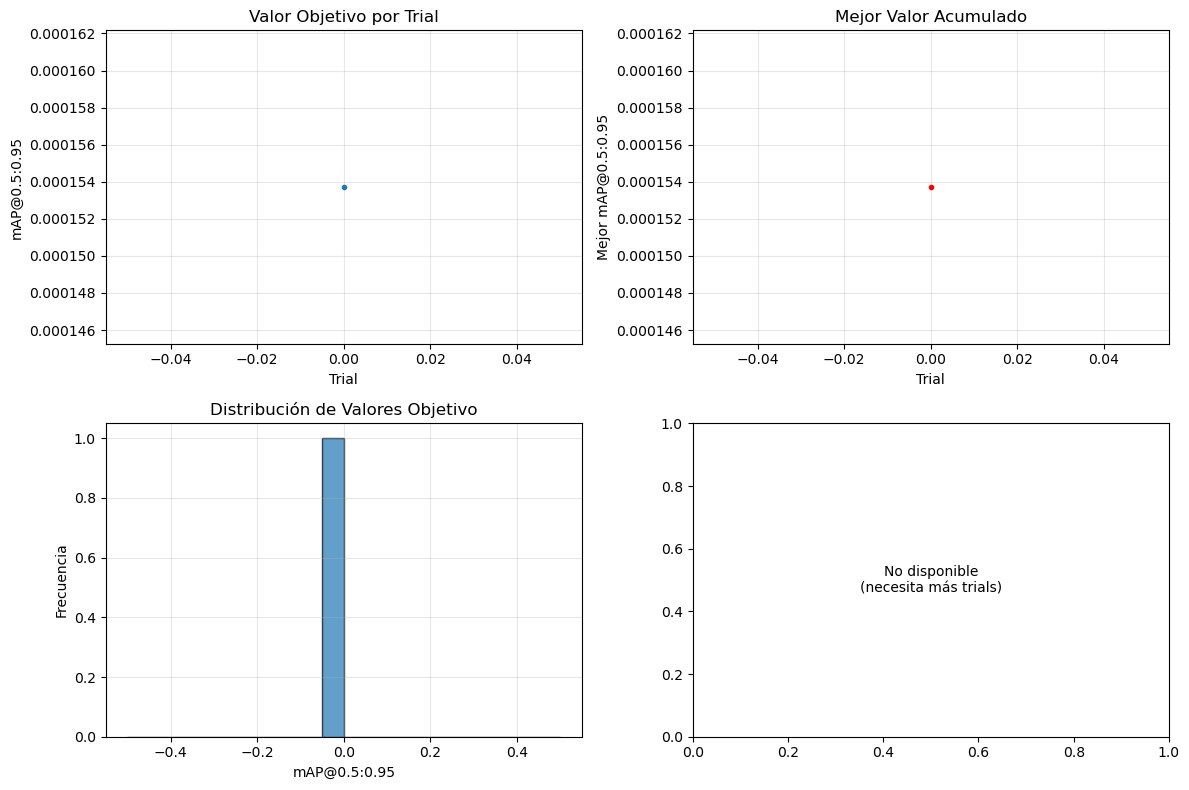

Figura guardada en: optuna/optuna_plots/optimization_yolov11n.png


In [ ]:
%matplotlib inline

optuna_utils.plot_optuna_optimization_history(study, output_path=image_optuna_path)

### **Train sin valización cruzada**

Entrenamos el modeelo final con los mejores hiperparámetros obtenidos con Optuna.

In [ ]:
with open(f"optuna/optuna_studies/{selected_model}_best_params.json", "r") as f:
    best_params = json.load(f)

print("Mejores hiperparámetros:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

results = model.train(
    data="cells.yaml",
    epochs=config.EPOCH_TRAIN,   
    imgsz=config.IMGSZ,          
    batch=config.BATCH,           
    name=model_output,
    save=True,         
    **best_params      
)

### **K-Fold Cross Validation**

### **Train Plots**

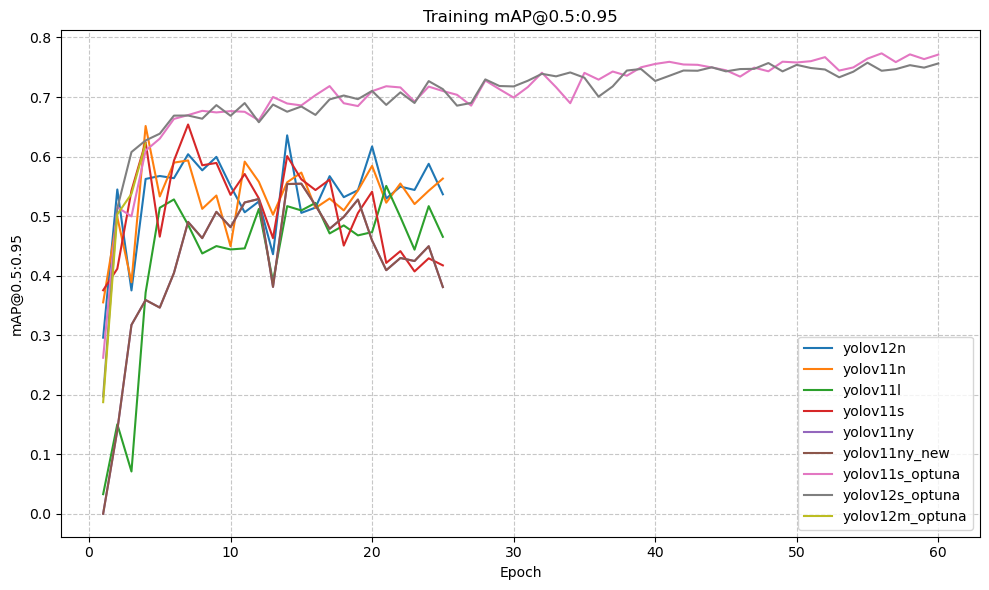

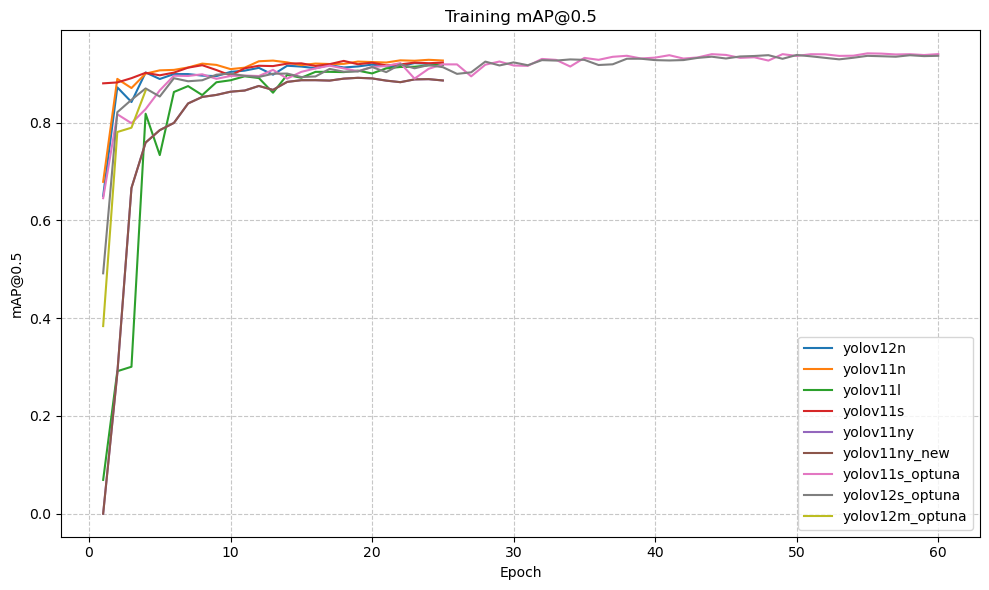

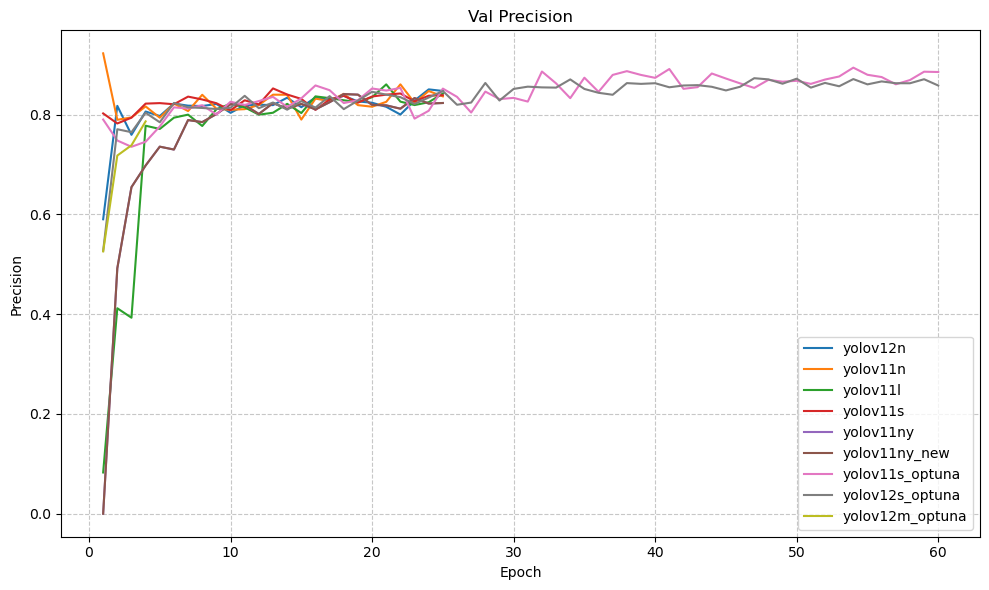

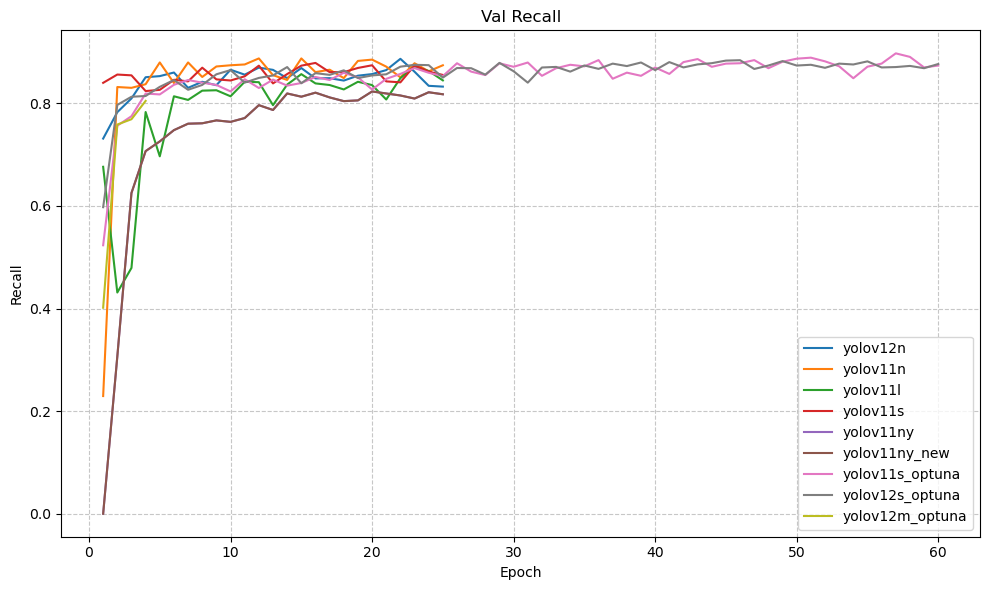

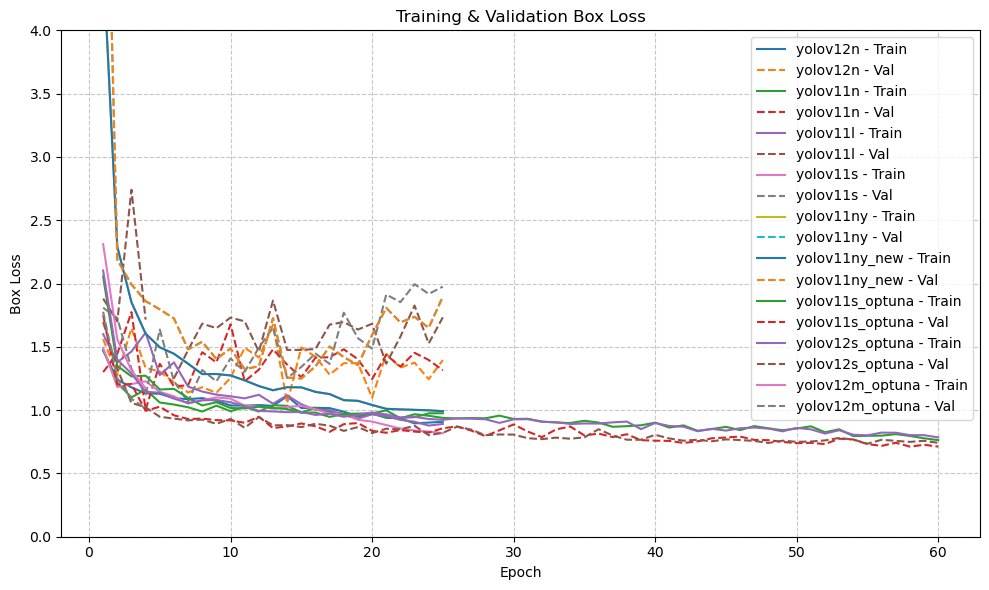

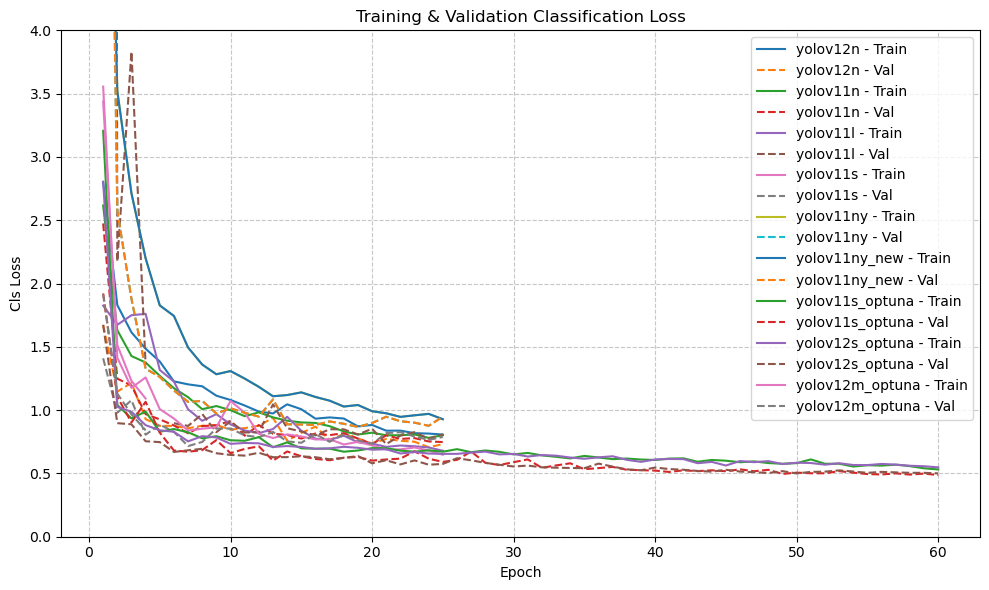

In [3]:
plots_dir = 'yolo_output/yolo_plots'
dfs = plot_utils.load_experiment_results(config.results_csv_paths)

plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50-95', 'metrics/mAP50-95(B)', 'Training mAP@0.5:0.95', 'mAP@0.5:0.95')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50', 'metrics/mAP50(B)', 'Training mAP@0.5', 'mAP@0.5')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'precision', 'metrics/precision(B)', 'Val Precision', 'Precision')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'recall', 'metrics/recall(B)', 'Val Recall', 'Recall')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'box_loss', ['train/box_loss', 'val/box_loss'], 
                               'Training & Validation Box Loss', 'Box Loss', True, (0, 4))
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'cls_loss', ['train/cls_loss', 'val/cls_loss'], 
                               'Training & Validation Classification Loss', 'Cls Loss', True, (0, 4))

## **Evaluaciones de empresa**

In [17]:
def process_images(directorio_entrada, directorio_referencia, directorio_salida, modelo_path):
    """
    Process all images in a directory with YOLO and compare with reference images.
    
    Args:
        directorio_entrada: Path to directory containing input images
        directorio_referencia: Path to directory containing reference images
        directorio_salida: Path to save output comparison images
        modelo_path: Path to YOLO model weights
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(directorio_salida):
        os.makedirs(directorio_salida)
        print(f"Directorio creado: {directorio_salida}")
    else:
        print(f"Usando directorio de salida: {directorio_salida}")
    
    modelo_personalizado = YOLO(modelo_path)
    
    archivos_entrada = [f for f in os.listdir(directorio_entrada) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not archivos_entrada:
        print(f"No se encontraron imágenes en {directorio_entrada}")
        return
    
    print(f"Procesando {len(archivos_entrada)} imágenes...")
    
    for nombre_archivo in archivos_entrada:
        print(f"Procesando: {nombre_archivo}")
        ruta_imagen = os.path.join(directorio_entrada, nombre_archivo)
        
        nombre_base = os.path.splitext(nombre_archivo)[0]
        nombre_referencia = f"{nombre_base}_.jpg"
        ruta_imagen_referencia = os.path.join(directorio_referencia, nombre_referencia)
        
        if not os.path.exists(ruta_imagen_referencia):
            print(f"Advertencia: No se encontró la imagen de referencia {nombre_referencia}")
            ruta_imagen_referencia = None
        
        resultados = modelo_personalizado(ruta_imagen)
        
        for r in resultados:
            num_detecciones = len(r.boxes)

            im_array = r.plot(labels=False, conf=True)

            font = cv2.FONT_HERSHEY_SIMPLEX
            texto_contador = f"{num_detecciones}"

            # Calculamos el tamaño del texto para posicionarlo correctamente
            textSize = cv2.getTextSize(texto_contador, font, 0.8, 2)[0]
            
            # Posicionamos en la esquina superior derecha con un margen de 20px
            text_x = im_array.shape[1] - textSize[0] - 20
            text_y = 30  # 30px desde la parte superior
            
            # Dibujamos el texto
            cv2.putText(im_array, texto_contador, (text_x, text_y), font, 0.8, (255, 255, 255), 2)
            
            if ruta_imagen_referencia:
                img_referencia = cv2.imread(ruta_imagen_referencia)
                
                h1, w1 = im_array.shape[:2]
                h2, w2 = img_referencia.shape[:2]
                
                if h1 != h2:
                    if h1 > h2:
                        new_w2 = int(w2 * (h1 / h2))
                        img_referencia = cv2.resize(img_referencia, (new_w2, h1))
                    else:
                        new_w1 = int(w1 * (h2 / h1))
                        im_array = cv2.resize(im_array, (new_w1, h2))
                
                img_combinada = cv2.hconcat([im_array, img_referencia])
                
                cv2.line(img_combinada, (im_array.shape[1], 0), (im_array.shape[1], img_combinada.shape[0]), (90, 70, 255), 2)
                
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(img_combinada, "YOLO", (10, 30), font, 1, (0, 255, 0), 2)
                cv2.putText(img_combinada, "IR", (im_array.shape[1] + 10, 30), font, 1, (0, 255, 0), 2)
                
                ruta_salida = os.path.join(directorio_salida, f"comparacion_{nombre_archivo}")
                cv2.imwrite(ruta_salida, img_combinada)
            else:
                ruta_salida = os.path.join(directorio_salida, f"yolo_{nombre_archivo}")
                cv2.imwrite(ruta_salida, im_array)
            
    print(f"Procesamiento completado. Resultados guardados en {directorio_salida}")

Añadir la evaluación sobre el conjunto de test

In [18]:
modelo_path = '.\\runs\\detect\\final_model_optunav11s2\\weights\\best.pt'

# DEFAULT dataset
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\INPUT DEFAULT",
    "..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\OUTPUT_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\YOLO_NEW",
    modelo_path
)

# TEST 2
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\INPUT TEST_2",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\OUTPUT_TEST 2_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\YOLO_NEW",
    modelo_path
)

# TEST 3
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 3\\INPUT_TEST 3",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 3\\OUTPUT_TEST 3_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 3\\YOLO_NEW",
    modelo_path
)

# TEST 4
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 4\\INPUT_TEST 4",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 4\\OUTPUT_TEST 4_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 4\\YOLO_NEW",
    modelo_path
)

Directorio creado: ..\03.Datasets\Evaluacion_Empresa\DEFAULT\YOLO_NEW
Procesando 94 imágenes...
Procesando: 110.jpg
Advertencia: No se encontró la imagen de referencia 110_.jpg

image 1/1 c:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\..\03.Datasets\Evaluacion_Empresa\DEFAULT\INPUT DEFAULT\110.jpg: 576x704 2 cells, 55.2ms
Speed: 7.6ms preprocess, 55.2ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 704)
Procesando: 116.jpg

image 1/1 c:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\..\03.Datasets\Evaluacion_Empresa\DEFAULT\INPUT DEFAULT\116.jpg: 576x704 35 cells, 26.2ms
Speed: 3.8ms preprocess, 26.2ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 704)
Procesando: 124.jpg
Advertencia: No se encontró la imagen de referencia 124_.jpg

image 1/1 c:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\..\03.Datasets\Evaluacion_Empresa\DEFAULT\INPUT D

añadir kfold y una función general que importe con un import para generar una carpeta con los resultados de la evaluación de cada imagen del test/defalut/eval_empresa 

Probar a entrenar Yolo con capas de atención y mucho más personalizados algunos modelos.

 hacer RFHF con yolo?

## **Conclusión**

## **Comentarios reunión semanal**

Para el power point usar el mes gratis de copilot, así lo redacto mejor y más rápido la presentación

"no es posible distinguir entre leucocitos y células germinales inmaduras con un alto grado de certeza (2)" https://pmc.ncbi.nlm.nih.gov/articles/PMC8915675/

Quiero probar este modelo: https://github.com/Peterande/D-FINE?tab=readme-ov-file